这个记事本是用来搭建CRNN网络的，用来做recognition

In [1]:
import os
import torch
from torch import nn
from torchvision import models
from utils import *
from matplotlib import pyplot as plt
import numpy as np

dataset = RecDataset("IAM", "train")
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

In [3]:
# test
model = models.resnet18(pretrained=True)
# model_cnn = nn.Sequential(*list(model.children())[:-1])
for chi in model.children():
    print(chi)
    print('-------------------')

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-------------------
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-------------------
ReLU(inplace=True)
-------------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-------------------
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (co

这里用resnet18除去最后的fc作为cnn的部分，lstm作为rnn的部分。<br>
输入1x128x128图片<br>
经过cnn部分，先是卷到了512x4x4，然后经过平均池化层变成512x1x1<br>
然后展平，经过线性变换放入lstm的hidden和cell

In [3]:
class CRNN(nn.Module):
    def __init__(self, num_classes=128, hidden_dim=256, io_dim=512, device='cuda:0'):
        super(CRNN, self).__init__()
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.io_dim = io_dim
        self.device = device
        self.max_len = 64  # max num of characters of the generated text
        self.conv1 = nn.Conv2d(1, 3, 1)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output dim is 512
        self.rnn = nn.LSTM(io_dim, hidden_dim, 1, batch_first=True)
        self.h0_fc = nn.Linear(512, hidden_dim)
        self.c0_fc = nn.Linear(512, hidden_dim)
        self.out_fc = nn.Linear(hidden_dim, num_classes)
        self.embedding = nn.Embedding(num_classes, io_dim)
        self.to(device)
    
    def init_state(self, img):
        # 通过CNN卷出 lstm 的 hidden state 和 cell state
        x = self.conv1(img)         # batch_size, 3, 64, 64
        x = self.cnn(x)             # batch_size, 512, 1, 1
        x = x.view(x.size(0), -1)   # batch_size, 512
        x = x.unsqueeze(0)          # 1, batch_size, 512
        h0 = self.h0_fc(x)          # 1, batch_size, hidden_dim
        c0 = self.c0_fc(x)          # 1, batch_size, hidden_dim
        return h0, c0
    
    def next_char(self, x, h_c_n):
        # print("next char x shape: ", x.shape)
        h_n, c_n = h_c_n
        # x: the embedding of the last character
        # h_n: the hidden state of the last character
        # c_n: the cell state of the last character
        x, (h_n, c_n) = self.rnn(x, (h_n, c_n))
        # print("next char rnn output x shape: ", x.shape)
        x = self.out_fc(x)
        # print("next char output x shape: ", x.shape)
        return x, (h_n, c_n)
    
    def forward(self, img):
        batch_size = img.size(0)
        h0, c0 = self.init_state(img)
        x = 2  # the index of the start token
        x = torch.tensor([x] * batch_size, dtype=torch.long).view(batch_size, 1).to(self.device)
        x = self.embedding(x)
        # print("after embedding x shape: ", x.shape)
        h_c_n = (h0, c0)
        temp = torch.zeros(batch_size, 1, self.num_classes).to(self.device)
        temp[:, 0, 2] = 1
        output = [temp]
        for i in range(1, self.max_len):
            x, h_c_n = self.next_char(x, h_c_n)
            output.append(x)
            x = x.argmax(dim=-1)
            x = self.embedding(x)
        output = torch.cat(output, dim=1)
        return output

In [5]:
# 测试CRNN进行预测时的形状是否符合要求

crnn = CRNN()
for step, (img, label) in enumerate(dataloader):
    img, label = img.to(crnn.device), label.to(crnn.device)
    print(img.shape)
    output = crnn(img)
    print(output.shape)
    break

torch.Size([10, 1, 128, 128])
torch.Size([10, 64, 128])


In [6]:
# 测试CRNN进行训练时的形状是否符合要求

crnn = CRNN()
for step, (img, label) in enumerate(dataloader):
    img, label = img.to(crnn.device), label.to(crnn.device)
    print(img.shape)
    h_n, c_n = crnn.init_state(img)
    print(h_n.shape, c_n.shape)
    break

torch.Size([10, 1, 128, 128])
torch.Size([1, 10, 256]) torch.Size([1, 10, 256])


In [7]:
# 可能要调的超参数有：hidden_dim, io_dim, lr, batch_size, num_epochs, dataset_name
def get_model_name(hidden_dim, io_dim, lr, batch_size, num_epochs, dataset_name):
    return f"crnn_{hidden_dim}_{io_dim}_{lr}_{batch_size}_{num_epochs}_{dataset_name}.pth"


def get_val_loss(model, dataloader, device):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    model.eval()
    loss = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss += criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
    return loss / len(dataloader)


# 下面是训练的代码，使用教师强制训练
def train_crnn(model, dataloader, learning_rate, epochs, device, start_epoch=0):
    if start_epoch:
        model_name = get_model_name(model.hidden_dim, model.io_dim, learning_rate, dataloader.batch_size, start_epoch, dataset.name)
        model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
        model.load_state_dict(torch.load(model_path + model_name))
        start_epoch += 1
        print(f"Model loaded from {model_name}")

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    model.to(device)
    for epoch in range(start_epoch, epochs):
        model.train()
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            loss = 0
            # 准备初始状态
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss = criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
            # mask = (target.argmax(-1) != 0).view(-1)
            # loss = loss[mask].mean()
            loss.backward()
            optimizer.step()
            if step % 10 == 0:
                print(f"Epoch {epoch}, Iter {step}, Loss {loss.item()}")
        
        # 计算验证集上的loss
        val_loss = get_val_loss(model, val_dataloader, device)
        print(f"Epoch {epoch}, Val Loss {val_loss.item()}")

        model_name = get_model_name(model.hidden_dim, model.io_dim, learning_rate, dataloader.batch_size, epoch, dataset.name)
        model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
        torch.save(model.state_dict(), model_path + model_name)
        print(f"Model saved as {model_name}")


model = CRNN()
model_name = get_model_name(model.hidden_dim, model.io_dim, 0.001, 64, 84, "IAM")
model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name))
dataset = RecDataset("CVL", "train")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)
val_dataset = RecDataset("CVL", "val")
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=8)
train_crnn(model, dataloader, 0.0001, 500, "cuda:0")

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Iter 0, Loss 2.4947664737701416
Epoch 0, Iter 10, Loss 1.9990307092666626
Epoch 0, Iter 20, Loss 2.1739325523376465
Epoch 0, Iter 30, Loss 2.270819902420044
Epoch 0, Iter 40, Loss 2.2612690925598145
Epoch 0, Iter 50, Loss 1.7928050756454468


KeyboardInterrupt: 

In [9]:
# load model
model = CRNN()
model_name = get_model_name(256, 512, 0.0001, 64, 84, "CVL")
model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name))
model.to("cuda:0")
model.eval()

def show_img(img):
    img = img.squeeze().cpu().numpy()
    plt.imshow(img, cmap="gray")
    plt.show()

def get_word(output):
    output = output.cpu().detach().numpy()
    word = ""
    for i in range(1, 64):
        o = np.argmax(output[i])
        if o == 3:
            break
        c = chr(o)
        word += c
    return word

# test
dataset = RecDataset("IAM", "val")
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

predict: to
answer:  to


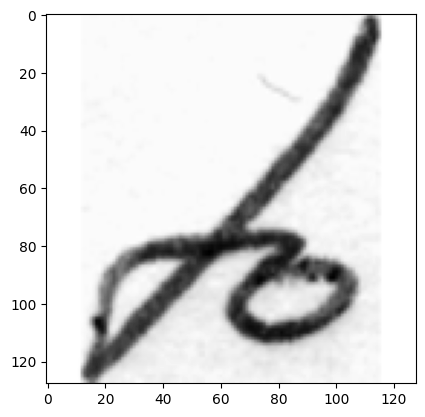

: 

In [32]:
for step, (img, label) in enumerate(dataloader):
    img, label = img.to("cuda:0"), label.to("cuda:0")
    output = model(img)
    print("predict:", get_word(output[0]))
    print("answer: ", get_word(label[0]))
    show_img(img[0])
    break